In [1]:
# Turbine file for AWAKEN Benchmark, Phase 1

In [2]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta

import xarray as xr

from collections import OrderedDict
from netCDF4 import Dataset

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil, io
for x in amrwindfedirs: sys.path.insert(1, x)

%matplotlib inline

import postproamrwindsample_xarray as ppsample
import postproengine as ppeng
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml as yaml
    print("# Loaded ruamel.yaml")
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False} 
except:
    import yaml as yaml
    print("# Loaded yaml")
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    
if useruamel: Loader=yaml.load
else:         Loader=yaml.safe_load

# Loaded ruamel.yaml


In [4]:


# ncfile='/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1/postprocessing.shortsummit/actuator_48000/WAF1-WTG0001.nc'
# group = 'surface_siteA1'
# itimevec = np.arange(100)

# ds = ppsample.getLineXR(ncfile, itimevec[:10], ['velocityx', 'velocityy', 'velocityz'], groupname=group, gettimes=True, includeattr=True)

# velx = np.array([g for k, g in ds['velocityx'].items()])


In [5]:


# ncfile='/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1/postprocessing.shortsummit/actuator48000/WAF1-WTG0001.nc'
# group = 'WAF1-WTG0001'
# itimevec = np.arange(100)

# ds = ppsample.getLineXR(ncfile, itimevec[:10], ['time','power'], groupname=group, gettimes=False, includeattr=True)

# power = np.array([g for k, g in ds['power'].items()])


In [6]:
#ds = xr.open_dataset(ncfile)
# ncfile_dir='/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1/postprocessing.shortsummit/actuator48000/'

# ds = nc.Dataset(ncfile,'r')
# print(ds.groups.items())
# print(ds['WAF1-WTG0001']['time'].values)
# print(ds['WAF1-WTG0001']['power'][0])

In [7]:
#_____________________________________________________________________________
# INPUT TO CHANGE BASED ON TIME RESOLUTION
#time_resolution = 60 # [s]
#_____________________________________________________________________________
# DO NOT CHANGE ANYTHING AFTER THIS
#_____________________________________________________________________________

tstart_sim = 24000 # Start time of turbine simulation (secs, in AMR-Wind time-frame)

# Define the dimensions# Define turbine names
N_AF = 126
N_KP = 88
num_turbines = N_AF + N_KP
#time_length = int(24*60*60/time_resolution)
#start_time = datetime(2023, 8, 23, 22, 15)  #This is the start time of the AMR-Wind simulation
#time_values = [start_time + timedelta(seconds=ds['times'][i]) for i in range(len(ds['times']))]

In [8]:
# Define the turbine names
AF_turbine_names = [ "WAF1_WTG%04i"%(i+1) for i in range(N_AF)]
KP_turbine_names  = [ "WIT_USKPL_SS001_WT%03i"%(i+1) for i in range(N_KP) ]
turbine_names     = AF_turbine_names + KP_turbine_names

# Get AMR-Wind Data

In [9]:
def getAFdata(ncfilelist, groupname, verbose=False):
    time = None
    pwr  = None
    vdisk = None
    vref  = None
    for ncfile in ncfilelist:
        if verbose: print(ncfile)
        ds = nc.Dataset(ncfile,'r')
        if time is None:
            time  = ds[groupname]['time'][:]
            pwr   = ds[groupname]['power'][:]
            vdisk = ds[groupname]['vdisk'][:]
            vref  = ds[groupname]['vref'][:]
        else:
            lasttime = time[-1]
            newtime  = ds[groupname]['time'][:]
            mask     = (newtime>lasttime)
            time     = np.append(time, newtime[mask])
            pwr      = np.append(pwr, ds[groupname]['power'][mask])
            vdisk    = np.append(vdisk, ds[groupname]['vdisk'][mask])
            vref     = np.append(vref, ds[groupname]['vref'][mask])
    vdisk = vdisk.reshape((len(time),3))
    vref  = vref.reshape((len(time),3))
    return time, pwr, vdisk, vref

In [10]:
rundir = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing'
AF_pwr = []
vdisk = []
vref = []
AF_vturb = []

for iturb in range(N_AF):
    actdirs = ['actuator48000', 'actuator68000']
    ncfilelist = [rundir + '/'+d+'/WAF1-WTG%04i.nc'%(iturb+1) for d in actdirs]
    group   =  'WAF1-WTG%04i'%(iturb+1)
    time, Tpwr, Tvdisk, Tvref = getAFdata(ncfilelist, group, verbose=True)
    AF_pwr.append(Tpwr)
    vdisk.append(Tvdisk)
    vref.append(Tvref)
    AF_vturb.append(np.sqrt(Tvref[:,0]**2 + Tvref[:,1]**2 + Tvref[:,2]**2))

/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator48000/WAF1-WTG0001.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator68000/WAF1-WTG0001.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator48000/WAF1-WTG0002.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator68000/WAF1-WTG0002.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator48000/WAF1-WTG0003.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator68000/WAF1-WTG0003.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator48000/WAF1-WTG0004.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/post_processing/actuator68000/WAF1-WTG0004.nc
/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_Farm

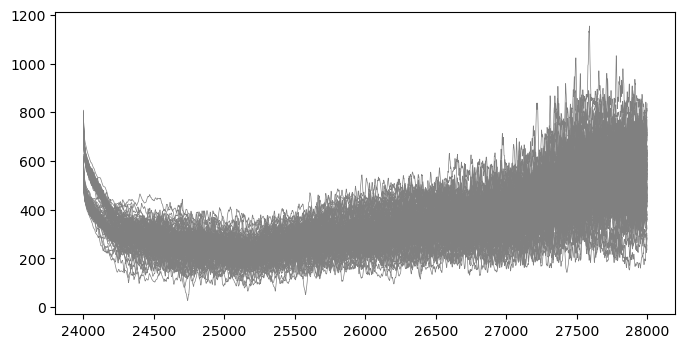

In [11]:
plt.figure(figsize=(8,4), dpi=100)
for p in AF_pwr:
    plt.plot(time, p/1000, '-', color='gray', lw=0.5)

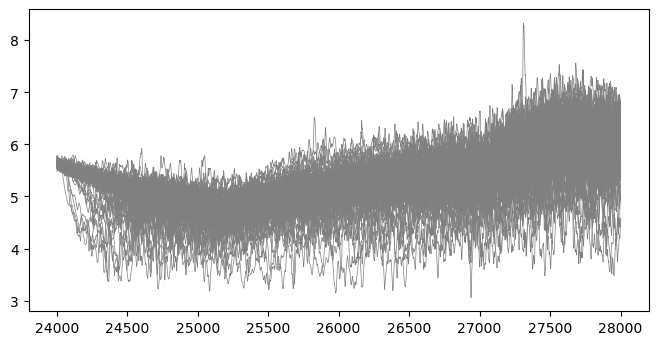

In [22]:
plt.figure(figsize=(8,4), dpi=100)
for U in AF_vturb:
    plt.plot(time, U, '-', color='gray', lw=0.5)

```python
#For the Armadillo Flats turbines - starting with WAF1 in the actuator dir
#NOTE: I'm getting the variable names using "ncdump -h actuator48000/WAF1-WTG0081.nc"
ncfile_dir='/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1/postprocessing.shortsummit/actuator48000/'
pwr=[]
vdisk=[]
vref=[]
for j, turb in enumerate(turbine_names):
    if turb[:3] == "WAF":
        amrturb=turb.replace('_','-')
        ncfile = ncfile_dir+amrturb+'.nc'
        #print(ncfile)
        ds = nc.Dataset(ncfile,'r')
        pwr.append(ds[amrturb]['power'][:])
        vdisk.append(ds[amrturb]['vdisk'][:])
        vref.append(ds[amrturb]['vref'][:])
        time = ds[amrturb]['time'][:]
        #print(pwr)
# print(ds.groups.items())
# print(ds['WAF1-WTG0001']['time'][4])
# print(ds['WAF1-WTG0001']['power'][0])
#WAF1-WTG0001.nc
```

In [12]:
print(time[0])
start_time = datetime(2023, 8, 23, 22, 15)  #This is the start time of the AMR-Wind simulation
    #print(start_time+ timedelta(seconds=ds['times'][0])) #This is the first time step to be saved in the simulation
time_values = [start_time + timedelta(seconds=time[i]) for i in range(len(time))]
print(start_time)
print(time_values[0])

24000.1
2023-08-23 22:15:00
2023-08-24 04:55:00.100000


## Process King Plains openfast files

In [13]:
#For the King Planes Turbines - OpenFast data
of_dir = "/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1.summit/"
run_ppeng = False

In [14]:
yamlstring="""

globalattributes:
  verbose: False
  udfmodules: []
  executeorder:
  - openfast
  #- plotcsv

#trange: &trange [65, 125]
  
openfast:
# For FSI case
- name: []
  filename: []
  vars:
  - Time
  - Wind1VelX
  - Wind1VelY
  - Wind1VelZ
  - GenPwr
  output_dir: OpenFAST_KP
  csv:  # Store information to CSV files
    individual_files: False
"""
f = io.StringIO(yamlstring)
yamldict = Loader(f, **loaderkwargs)

In [15]:
# Fill in the names and filenames
KPturbnames = ['T%02i'%i for i in range(N_KP)]
KPturbdirs = [of_dir + '/WIT_USKPL_SS001_WT%03i_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.T%i.out'%(i+1,i) for i in range(88)]
KPturbdirs[0] = KPturbdirs[0].replace('.T0.out', '.out')
yamldict['openfast'][0]['name']     = KPturbnames 
yamldict['openfast'][0]['filename'] = KPturbdirs
#print(yamldict['openfast'][0]['name'])
#print(yamldict['openfast'][0]['filename'])

In [16]:
# Run the driver
if run_ppeng:
    ppeng.driver(yamldict, verbose=True)

In [17]:
# Reload the data in the right time format
def read_OFturbdat(csvfile, timetointerp, toffset,tmask):
    csvdat = pd.read_csv(csvfile)
    csvTime = csvdat['Time']
    csvGenPwr  = csvdat['GenPwr']
    csvUx      = csvdat['Wind1VelX']
    csvUy      = csvdat['Wind1VelY']
    csvUz      = csvdat['Wind1VelZ']
    
    csvU       = np.sqrt(csvUx**2 + csvUy**2 + csvUz**2)
    
    interpPwr  = np.interp(timetointerp, csvTime.values+toffset, csvGenPwr.values, right=np.nan)
    interpU    = np.interp(timetointerp, csvTime.values+toffset, csvU.values, right=np.nan)
    
    # Mask out bad times
    mask = ((tmask[0]<timetointerp-toffset) & (timetointerp-toffset < tmask[1]))
    #print(len(mask))
    interpPwr[mask] = np.nan
    interpU[mask]   = np.nan
    #print(csvTime.values[-1]+toffset, timetointerp[-1])
    #print(len(csvTime), len(timetointerp))
    #print(interpPwr)
    return interpPwr, interpU

#interpPwr = read_OFturbdat('OpenFAST_KP/T00.csv', time, tstart_sim)

In [18]:
KP_pwr = []
KP_vturb = []
for iturb in range(N_KP):
    interpPwr, interpU = read_OFturbdat('OpenFAST_KP/T%02i.csv'%iturb, time, tstart_sim, [2200, 3800])
    KP_pwr.append(interpPwr)
    KP_vturb.append(interpU)

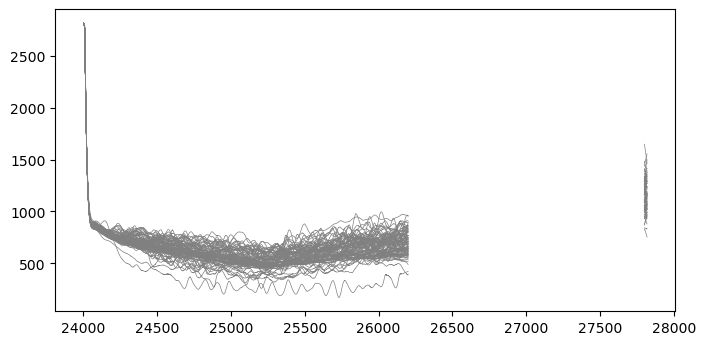

In [19]:
plt.figure(figsize=(8,4), dpi=100)
for p in KP_pwr:
    plt.plot(time, p, '-', color='gray', lw=0.5)

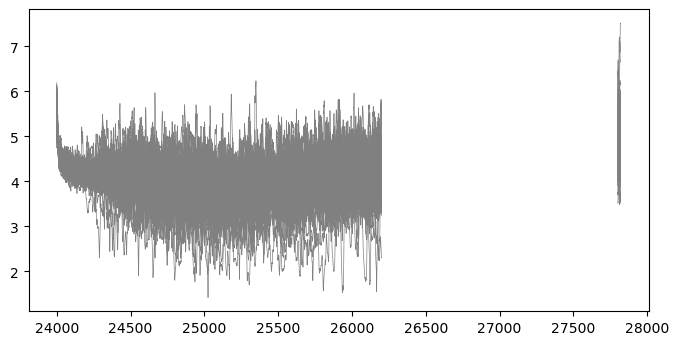

In [20]:
plt.figure(figsize=(8,4), dpi=100)
for U in KP_vturb:
    plt.plot(time, U, '-', color='gray', lw=0.5)

```
#!OUTFILE={OF}
os.system("""
#OUTFILE=/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/FarmRuns/BM1_FarmRunProd1/WIT_USKPL_SS001_WT088_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.*out
OUTFILE=$OF
grepOFcols() {
    OFfile=$1
    col1=$2
    col2=$3
    headers=`head -n7 $OFfile |tail -n1 |fmt -1 |nl`
    col1num=`echo "$headers" |grep "$col1" |awk '{print $1}'`
    col2num=`echo "$headers" |grep "$col2" |awk '{print $1}'`

    tail -n +7 $OFfile | awk -v col1num=$col1num -v col2num=$col2num '{print $col1num, $col2num}'
}

extractOFvar() {
    OUTFILE=$1
    VAR=$2
    DATADIR=$3
    grepOFcols $OUTFILE Time $VAR > $DATADIR/NALUWIND_turb_${VAR}.dat
}
grepOFcols {OF} Time GenPwr > NALUWIND_turb_GenPwr.dat
#grepOFcols $OUTFILE Time GenPwr > NALUWIND_turb_GenPwr.dat
#extractOFvar $OUTFILE GenTq $DATADIR

""")
```

## write the netCDF file

In [23]:
allpwr = np.array(AF_pwr + KP_pwr).transpose()
allvturb   = np.array(AF_vturb + KP_vturb).transpose()
print(allpwr.shape)

(39990, 214)


In [24]:
# Create a netCDF file
with nc.Dataset("template_turbine_response.nc", "w") as f:
    # Create dimensions
    f.createDimension("time", len(time))
    f.createDimension("num_turbines", num_turbines)

    # Create variables
    hub_height_WS = f.createVariable("hub_height_WS", "f4", ("time", "num_turbines"))
    power = f.createVariable("power", "f4", ("time", "num_turbines"))

    # Fill variables with NaNs
    hub_height_WS[:] = allvturb
    power[:] = allpwr

    # Assign turbine names as an attribute
    f.turbine_names = turbine_names

    # Create time values
    #start_time = datetime(2023, 8, 24, 0, 0)
    #time_values = [start_time + timedelta(seconds=time_resolution*i) for i in range(time_length)]
    start_time = datetime(2023, 8, 23, 22, 15)  #This is the start time of the AMR-Wind simulation
    #print(start_time+ timedelta(seconds=time[i])) #This is the first time step to be saved in the simulation
    time_values = [start_time + timedelta(seconds=time[i]) for i in range(len(time))]
    
    # Write time values to the file
    time_var = f.createVariable("time", "i8", ("time",))
    time_var.units = "seconds since 2023-08-23 22:15:00"
    time_var.calendar = "gregorian"
    time_var[:] = nc.date2num(time_values, units=time_var.units, calendar=time_var.calendar)

    # Add attributes
    f.setncattr("time", "UTC dates")

In [27]:
# Open the netCDF file
dss = xr.open_dataset("template_turbine_response.nc")

#for i in range(len(dss['time'])):
#    for j,turb in enumerate(turbine_names):
#        dss['power'][i][j] = pwr[j]
# Display dataset information
print(dss)


<xarray.Dataset>
Dimensions:        (time: 39990, num_turbines: 214)
Coordinates:
  * time           (time) datetime64[ns] 2023-08-24T04:55:00 ... 2023-08-24T0...
Dimensions without coordinates: num_turbines
Data variables:
    hub_height_WS  (time, num_turbines) float32 ...
    power          (time, num_turbines) float32 ...
Attributes:
    turbine_names:  ['WAF1_WTG0001', 'WAF1_WTG0002', 'WAF1_WTG0003', 'WAF1_WT...
    time:           UTC dates
